# Collecte des données ``covid``

### Importation des bibliothèques et de leurs packages

In [1]:
# Fonctions 'bash'
import os
import sys
from pathlib import Path

# Connexion à la base de données Mongo
import pymongo
from pymongo import MongoClient, ASCENDING, DESCENDING

# Collecte des données et écriture
import json
from bson import json_util, ObjectId

from collections import defaultdict
import csv

import string

# Recherche d'expressions régulières
import re
from unidecode import unidecode # transormation

# Mise en forme du texte python
from pprint import pprint

# Connexion à Wikidata
from wikidata.client import Client

# Gestion des formats 'date'
from datetime import datetime, date, time, timedelta

# Visualisation des données
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Traitement du langage naturel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

### Connexion à la base de données

In [2]:
host = "ec2-15-188-255-64.eu-west-3.compute.amazonaws.com" 
port = 27017
username = "semal"
password = "$hMN3PU]V][xR]zn"

mongo_client = MongoClient(host=host, port=port, username=username, password=password)

db = mongo_client["media_analysis"]["articles"]

### Extraction des fichiers ``json``

#### Choix des sources à extraire

In [3]:
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

#### Choix des mots-clés

In [4]:
keywords = [
    "corona", "covid",
    "sras-", "sars-",
    "pandémie", "pandemie",
    "confinement",
    "distanciation sociale",
    "crise sanitaire"
]

regex_pattern = r"[\w-]*(" + "|".join(keywords) + r")[\w-]*"
regex = re.compile(regex_pattern, re.IGNORECASE)

#### Extraction des articles à l'aide de la regex

In [5]:
if not os.path.exists("./data"):
    os.mkdir("./data")

for source in relevant_sources:
    start_date = datetime(2020, 5, 1)
    delta = timedelta(days=1)
    end_date = datetime.now() 
    
    print(f"\n{source}")
    print("-------------------")
    if not os.path.exists(f"./data/{source}"):
        os.mkdir(f"./data/{source}")
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"

        if not os.path.isfile(f"./data/{source}/{filename}"):
            query = {
                "meta.source.name" : source,
                "date": {
                    "$gte": start_date, 
                    "$lt": start_date + delta},
                "$or": [
                    {"title": {"$regex": regex}},
                    {"text": {"$regex": regex}}]
            }
            projection = {
                "_id": 1,
                "date": 1,
                "meta.source.name": 1,
                "title": 1,
                "text": 1
            }
            subset = db.find(query, projection).sort("date", ASCENDING)
            subset_count = db.count_documents(query)
            print(f"Nombre de documents à écrire pour {source} le {start_date.date()}: {subset_count}")

            with open(f"./data/{source}/{filename}", "w", encoding="utf-8") as f:
                for document in subset:
                    json.dump(document, f, default=json_util.default, ensure_ascii=False)
                    f.write("\n")

        start_date += delta
        
print("\nExtraction du subset covid OK")


lesoir.be
-------------------
Nombre de documents à écrire pour lesoir.be le 2024-05-14: 0
Nombre de documents à écrire pour lesoir.be le 2024-05-15: 0

lalibre.be
-------------------
Nombre de documents à écrire pour lalibre.be le 2024-05-14: 9
Nombre de documents à écrire pour lalibre.be le 2024-05-15: 0

rtbf.be
-------------------
Nombre de documents à écrire pour rtbf.be le 2024-05-14: 3
Nombre de documents à écrire pour rtbf.be le 2024-05-15: 0

rtlinfo.be
-------------------
Nombre de documents à écrire pour rtlinfo.be le 2024-05-14: 0
Nombre de documents à écrire pour rtlinfo.be le 2024-05-15: 0

dhnet.be
-------------------
Nombre de documents à écrire pour dhnet.be le 2024-05-14: 7
Nombre de documents à écrire pour dhnet.be le 2024-05-15: 0

sudinfo.be
-------------------
Nombre de documents à écrire pour sudinfo.be le 2024-05-14: 0
Nombre de documents à écrire pour sudinfo.be le 2024-05-15: 0

lavenir.net
-------------------
Nombre de documents à écrire pour lavenir.net le 

#### Extraction de tous les topics et entités avec un certain seuil

In [6]:
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

def extract_document_ids_and_data_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            oid = data["_id"]["$oid"]
            yield oid, data

def get_topics_and_entities(document):
    coarseTopics = document.get("textrazor_response", {}).get("response", {}).get("coarseTopics", [])
    topics = document.get("textrazor_response", {}).get("response", {}).get("topics", [])
    entities = document.get("textrazor_response", {}).get("response", {}).get("entities", [])

    coarseTopics_set = set()
    for coarseTopic in coarseTopics:
        if coarseTopic["score"] >= 0.8:
            extracted_coarseTopic = {
                "label": coarseTopic["label"],
                "score": coarseTopic["score"]
            }
            coarseTopics_set.add(json.dumps(extracted_coarseTopic, ensure_ascii=False))

    extracted_coarseTopics = sorted([json.loads(coarseTopic) for coarseTopic in coarseTopics_set], key=lambda x: x["score"], reverse=True)

    topics_set = set()
    for topic in topics:
        if topic["score"] >= 0.8:
            extracted_topic = {
                "label": topic["label"],
                "score": topic["score"]
            }
            topics_set.add(json.dumps(extracted_topic, ensure_ascii=False))

    extracted_topics = sorted([json.loads(topic) for topic in topics_set], key=lambda x: x["score"], reverse=True)

    entities_set = set()
    for entity in entities:
        if entity["confidenceScore"] > 0.5 and entity["relevanceScore"] > 0.0:
            extracted_entity = {
                "entityId": entity["entityId"],
                "type": entity.get("type", []),
                "relevanceScore": entity["relevanceScore"],
                "confidenceScore": entity["confidenceScore"]
            }
            entities_set.add(json.dumps(extracted_entity, ensure_ascii=False))

    extracted_entities = sorted([json.loads(entity) for entity in entities_set], key=lambda x: x["relevanceScore"], reverse=True)

    data = {
        "coarseTopics": extracted_coarseTopics,
        "topics": extracted_topics,
        "entities": extracted_entities
    }

    return data


start_date = datetime(2020, 5, 1)
end_date = datetime.now()

for source in relevant_sources:
    directory = f"./data/{source}"

    print(f"\n{source}")
    print("-------------------")

    for filename in os.listdir(directory):
        date_str = filename.split("_")[1].split(".")[0]
        file_date = datetime.strptime(date_str, "%Y%m%d")
        
        if start_date <= file_date < end_date:
            filepath = os.path.join(directory, filename) 
            ids_and_data = extract_document_ids_and_data_from_file(filepath)
            
            if not os.path.exists(f"./data/tmp/textrazor/{source}"):
                os.makedirs(f"./data/tmp/textrazor/{source}")

            output_filename = f"{filename[:-5]}.json"
            output_filepath = os.path.join(f"./data/tmp/textrazor/{source}", output_filename)
            
            if os.path.exists(output_filepath):
                continue
                
            updated_document = [] # liste pour stocker les documents à jour

            for oid, data in ids_and_data:
                article = db.find_one({"_id": ObjectId(oid)})

                if article:
                    extracted_data = get_topics_and_entities(article)
                    data.update(extracted_data)
                    updated_document.append(data)

            if updated_document:
                # Écrire les documents mis à jour dans le fichier de sortie
                with open(output_filepath, "w", encoding="utf-8") as f:
                    for data in updated_document:
                        json.dump(data, f, default=json_util.default, ensure_ascii=False)
                        f.write("\n")

                print(f"Le fichier {filename} a été traité avec succès.")
            else:
                # Écrire un document vide dans le fichier de sortie
                with open(output_filepath, "w", encoding="utf-8") as f:
                    f.write("\n")

                print(f"Le fichier {filename} est vide. Un document vide a été créé.")

print("\nExtraction Textrazor OK")


lesoir.be
-------------------
Le fichier lesoir.be_20240514.json est vide. Un document vide a été créé.
Le fichier lesoir.be_20240515.json est vide. Un document vide a été créé.

lalibre.be
-------------------
Le fichier lalibre.be_20240514.json a été traité avec succès.
Le fichier lalibre.be_20240515.json est vide. Un document vide a été créé.

rtbf.be
-------------------
Le fichier rtbf.be_20240514.json a été traité avec succès.
Le fichier rtbf.be_20240515.json est vide. Un document vide a été créé.

rtlinfo.be
-------------------
Le fichier rtlinfo.be_20240514.json est vide. Un document vide a été créé.
Le fichier rtlinfo.be_20240515.json est vide. Un document vide a été créé.

dhnet.be
-------------------
Le fichier dhnet.be_20240514.json a été traité avec succès.
Le fichier dhnet.be_20240515.json est vide. Un document vide a été créé.

sudinfo.be
-------------------
Le fichier sudinfo.be_20240514.json est vide. Un document vide a été créé.
Le fichier sudinfo.be_20240515.json est 

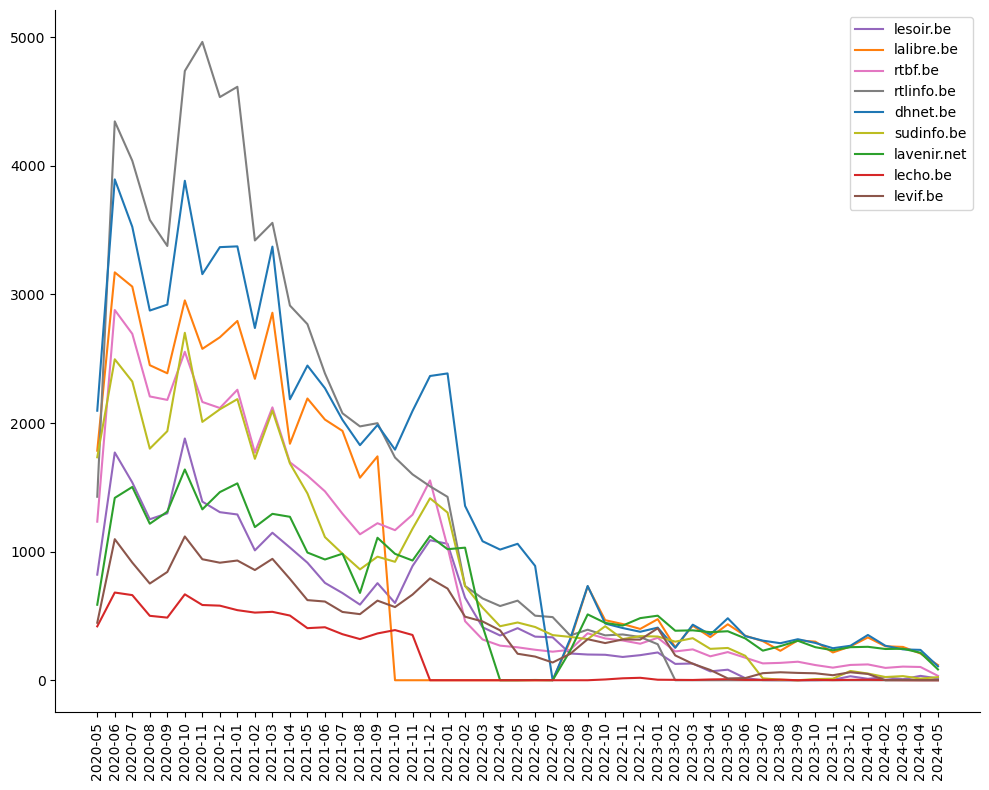

In [7]:
# Créer un dictionnaire pour associer les sources aux couleurs (copier-coller le dictionnaire de votre sortie)
source_color_mapping = {
    'dhnet.be': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    'lalibre.be': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    'lavenir.net': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    'lecho.be': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    'lesoir.be': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    'levif.be': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    'rtbf.be': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    'rtlinfo.be': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    'sudinfo.be': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
}

# Initialiser les variables
articles_extraits_par_journal = {source: {} for source in relevant_sources}

for source in relevant_sources:
    articles_extraits_par_journal[source] = {}
    start_date = datetime(2020, 5, 1)
    end_date = datetime.now()
    delta = timedelta(days=1)
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]
            
            month_year = start_date.strftime("%Y-%m")
            if month_year in articles_extraits_par_journal[source]:
                articles_extraits_par_journal[source][month_year] += len(articles)
            else:
                articles_extraits_par_journal[source][month_year] = len(articles)
        
        start_date += delta

# Initialiser la figure et les axes
fig, ax = plt.subplots()

# Graphique du nombre d'articles extraits par journal et par mois
for source in relevant_sources:
    months = list(articles_extraits_par_journal[source].keys())
    counts = list(articles_extraits_par_journal[source].values())
    color = source_color_mapping.get(source)
    ax.plot(months, counts, label=source, color=color)  
    
# Ajoute la légende et les étiquettes d'axe
ax.legend()

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Évolution du nombre d'articles extraits par journal.png")

plt.savefig(output_path)
plt.show()
plt.close()


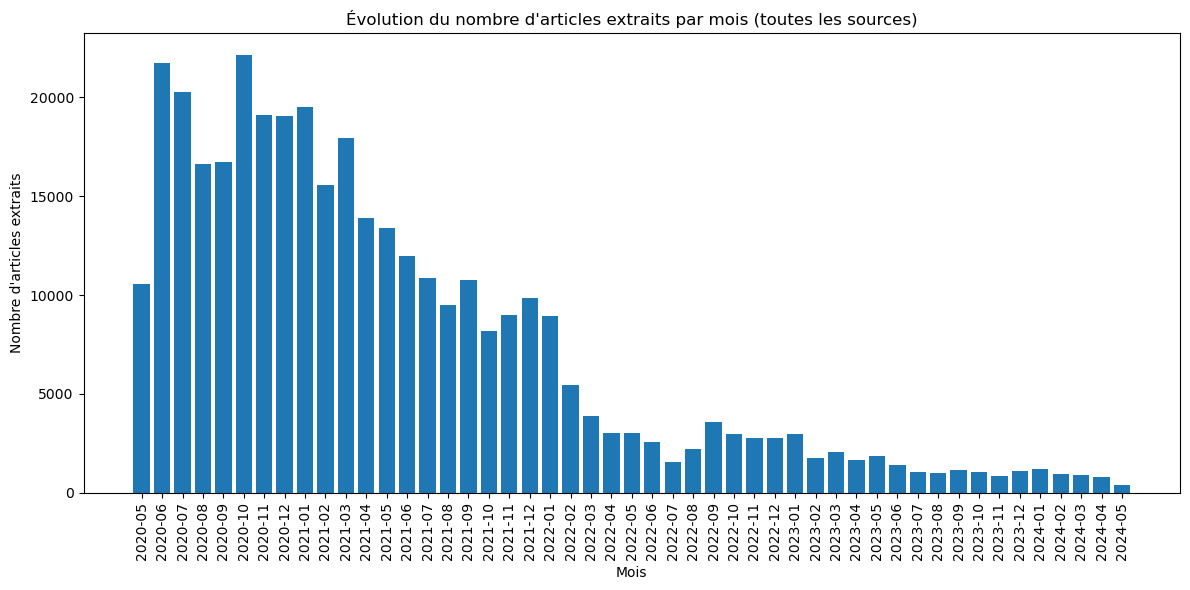

In [8]:
# Liste des sources pertinentes
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

# Initialiser la variable pour stocker les données par mois
articles_extraits_par_mois = {}

# Parcourir les sources pertinentes
for source in relevant_sources:
    start_date = datetime(2020, 5, 1)
    end_date = datetime.now()
    delta = timedelta(days=1)
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]
            
            month_year = start_date.strftime("%Y-%m")
            if month_year in articles_extraits_par_mois:
                articles_extraits_par_mois[month_year] += len(articles)
            else:
                articles_extraits_par_mois[month_year] = len(articles)
        
        start_date += delta

# Trier les données par mois
sorted_articles_extraits_par_mois = dict(sorted(articles_extraits_par_mois.items()))

# Création du graphique en barres
fig, ax = plt.subplots(figsize=(12, 6))
months = list(sorted_articles_extraits_par_mois.keys())
counts = list(sorted_articles_extraits_par_mois.values())

ax.bar(months, counts)

# Ajouter des étiquettes et un titre
ax.set_xlabel("Mois")
ax.set_ylabel("Nombre d'articles extraits")
ax.set_title("Évolution du nombre d'articles extraits par mois (toutes les sources)")

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=90)

# Ajustements de mise en page
plt.tight_layout()

# Sauvegarde du graphique
output_directory = "./data/plots/corpus"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Évolution du nombre d'articles extraits par mois.png")
plt.savefig(output_path)
plt.show()
plt.close()


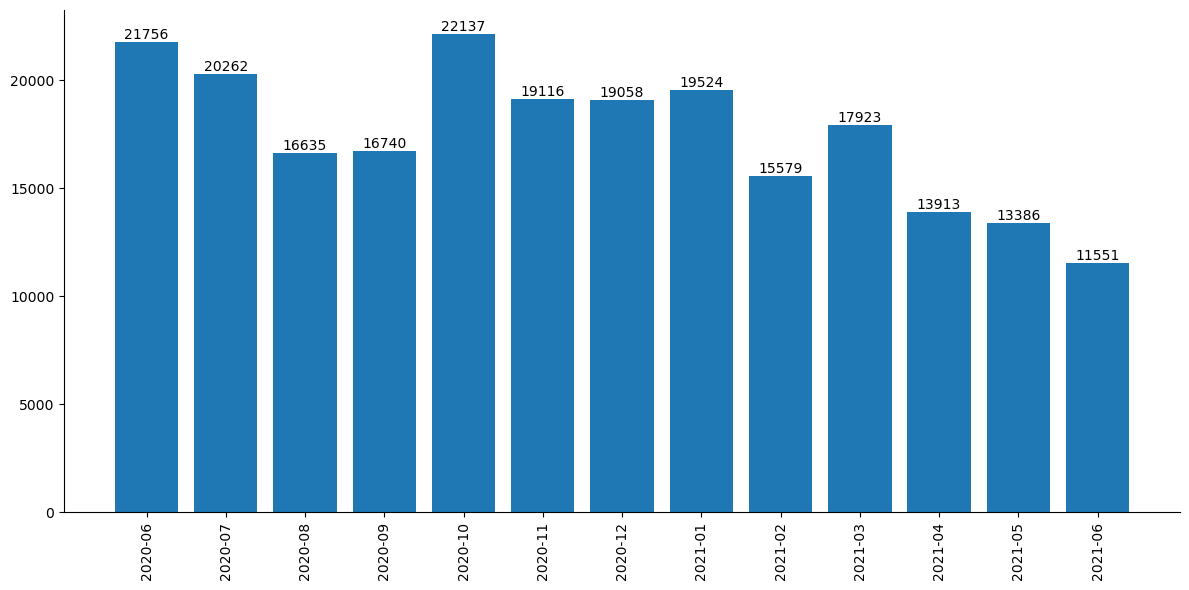

In [9]:
# Liste des sources pertinentes
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

# Initialiser la variable pour stocker les données par mois
articles_extraits_par_mois = {}

# Parcourir les sources pertinentes
for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 6, 30)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]
            
            month_year = start_date.strftime("%Y-%m")
            if month_year in articles_extraits_par_mois:
                articles_extraits_par_mois[month_year] += len(articles)
            else:
                articles_extraits_par_mois[month_year] = len(articles)
        
        start_date += delta

# Trier les données par mois
sorted_articles_extraits_par_mois = dict(sorted(articles_extraits_par_mois.items()))

# Création du graphique en barres avec les valeurs au-dessus des barres
fig, ax = plt.subplots(figsize=(12, 6))
months = list(sorted_articles_extraits_par_mois.keys())
counts = list(sorted_articles_extraits_par_mois.values())

bars = ax.bar(months, counts)

# Ajout des valeurs au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=90)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Ajustements de mise en page
plt.tight_layout()

# Sauvegarde du graphique
output_directory = "./data/plots/corpus"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Évolution du nombre d'articles extraits par mois_juin2020_juin2021.png")
plt.savefig(output_path)
plt.show()
plt.close()


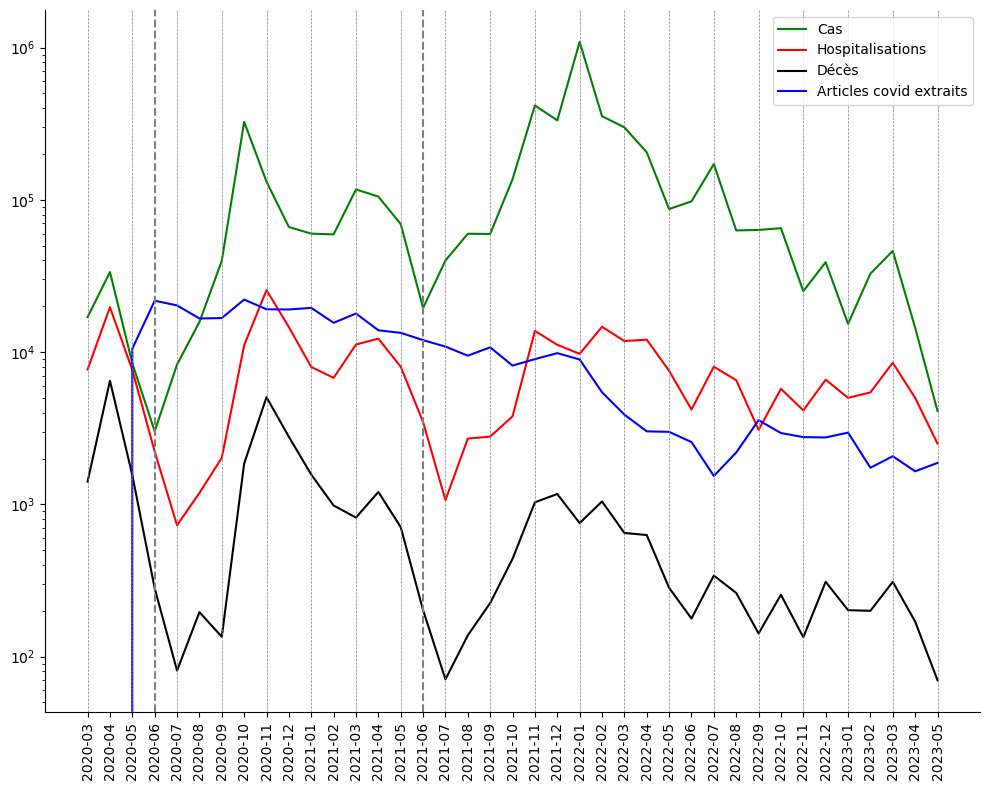

In [10]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
cases = data.iloc[:, 1]
hospitalizations = data.iloc[:, 2]
deaths = data.iloc[:, 3]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-03'].index[0]
end_index = months[months == '2023-05'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
cases = cases[start_index:end_index + 1]
hospitalizations = hospitalizations[start_index:end_index + 1]
deaths = deaths[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 3, 1)
    end_date = datetime(2023, 6, 1)
    delta = timedelta(days=1)

    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0 
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)
            
        start_date += delta

# Création de la figure et des axes
fig, ax = plt.subplots()

# Graphique du nombre total de cas, hospitalisations et décès
ax.plot(months_covid, cases, label="Cas", color="green")
ax.plot(months_covid, hospitalizations, label="Hospitalisations", color="red")
ax.plot(months_covid, deaths, label="Décès", color="black")

# Graphique du nombre total d'articles extraits par mois en échelle logarithmique
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax.plot(months_articles, counts_articles, label="Articles covid extraits", color="blue")

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajout des lignes verticales spécifiques à juin 2020 et juin 2021
ax.axvline(x='2020-06', color='gray', linestyle='--', linewidth=1.5)
ax.axvline(x='2021-06', color='gray', linestyle='--', linewidth=1.5)

# Appliquer une échelle logarithmique sur l'axe des y
ax.set_yscale("log")

# Ajouter la légende et les étiquettes d'axe
ax.legend()

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Évolution du nombre de cas, d'hospitalisations, de décès et d'articles extraits.png")

plt.savefig(output_path)
plt.show()
plt.close()


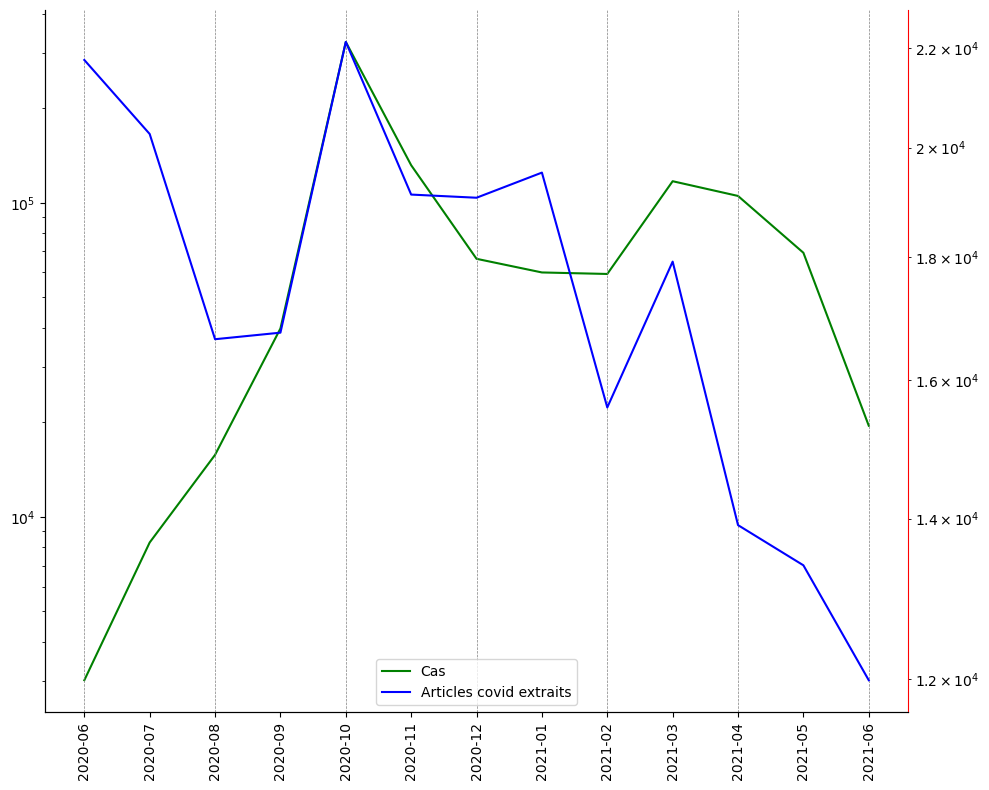

In [11]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
cases = data.iloc[:, 1]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-06'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
cases = cases[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 7, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0 
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta

# Création du premier graphique : nombre de cas
fig, ax1 = plt.subplots()
ax1.plot(months_covid, cases, label="Cas", color="green")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Comparaison du nombre de cas et d'articles extraits pour toutes les sources.png")

plt.savefig(output_path)
plt.show()
plt.close()


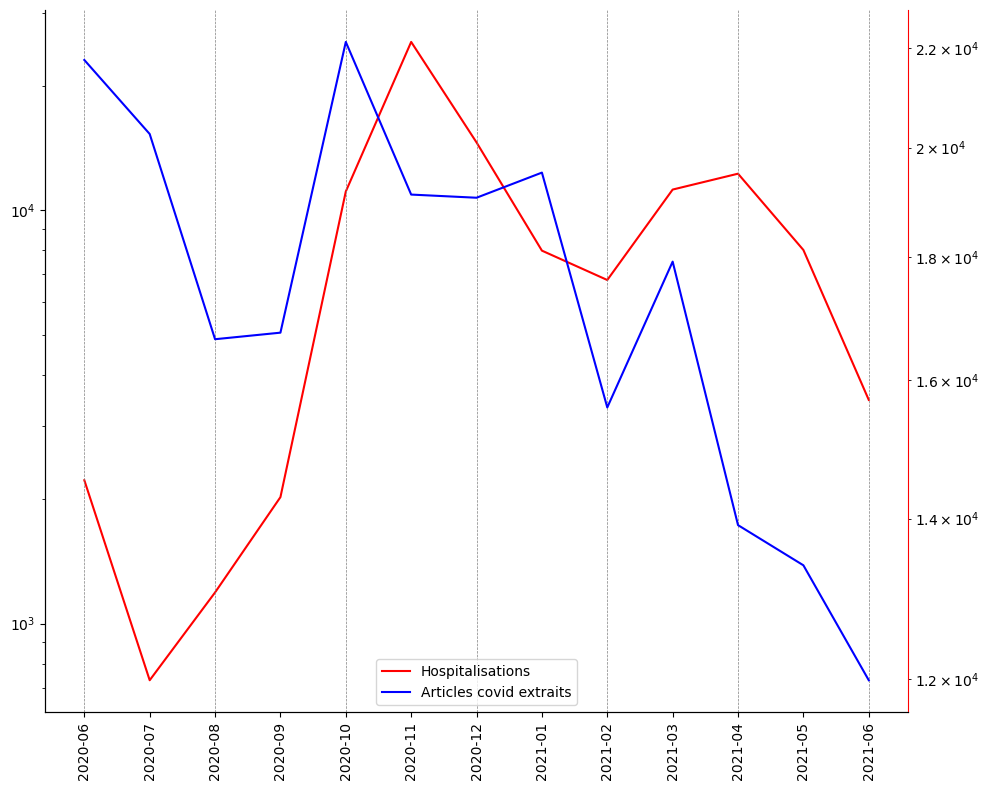

In [12]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
hospitalizations = data.iloc[:, 2]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-06'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
hospitalizations = hospitalizations[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 7, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0  # Initialisation à zéro
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta

# Création du premier graphique : nombre d'hospitalisations
fig, ax1 = plt.subplots()
ax1.plot(months_covid, hospitalizations, label="Hospitalisations", color="red")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Comparaison du nombre d'hospitalisations et d'articles extraits pour toutes les sources.png")

plt.savefig(output_path)
plt.show()
plt.close()


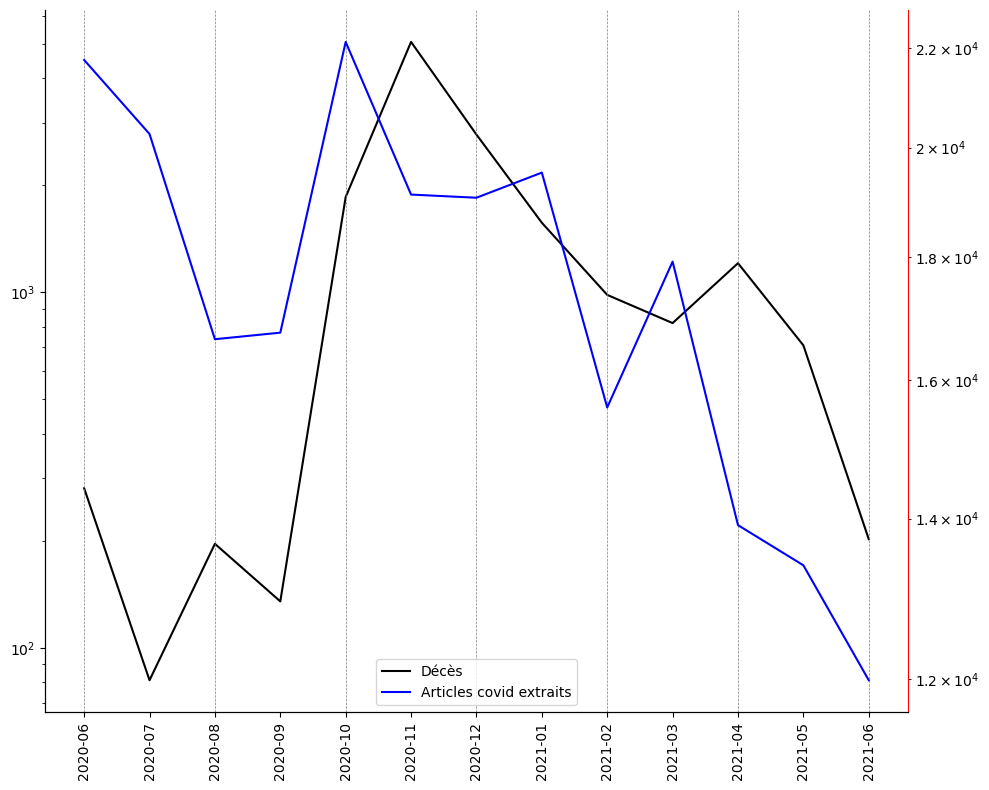

In [13]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
deaths = data.iloc[:, 3]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-06'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
deaths = deaths[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 7, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta

# Création du premier graphique : nombre de décès
fig, ax1 = plt.subplots()
ax1.plot(months_covid, deaths, label="Décès", color="black")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "COVID_Comparaison du nombre de décès et d'articles extraits pour toutes les sources.png")

plt.savefig(output_path)
plt.show()
plt.close()


#### Calcul du nombre moyen de mots dans les articles par source et par mois

In [14]:
def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")

def count_words(text):
    return len(word_tokenize(text))

def average_word_count_by_month(directory):
    average_word_counts = {}
    total_words_by_month = {}
    total_texts_by_month = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path) or not file_path.endswith('.json'):
            continue

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    if text:
                        date_str = get_date_from_filename(filename)
                        total_words_by_month[date_str] = total_words_by_month.get(date_str, 0) + count_words(text)
                        total_texts_by_month[date_str] = total_texts_by_month.get(date_str, 0) + 1
                except json.JSONDecodeError:
                    continue

    for date_str in total_words_by_month:
        if total_texts_by_month[date_str] > 0:
            average_word_counts[date_str] = int(total_words_by_month[date_str] / total_texts_by_month[date_str])
        else:
            average_word_counts[date_str] = 0

    return average_word_counts


relevant_sources = ['lesoir.be', 'lalibre.be', 'rtbf.be', 'rtlinfo.be', 'dhnet.be', 'sudinfo.be', 'lavenir.net', 'lecho.be', 'levif.be']

for source in relevant_sources:
    data_directory = f"./data/{source}"
    average_word_counts = average_word_count_by_month(data_directory)
    print(f"Source : {source}")
    print("-------------------")
    print(f"Nombre moyen de mots par texte par mois : {average_word_counts}")
    print("-------------------")


Source : lesoir.be
-------------------
Nombre moyen de mots par texte par mois : {'May 2020': 230, 'Jun 2020': 223, 'Jul 2020': 204, 'Aug 2020': 223, 'Sep 2020': 215, 'Oct 2020': 190, 'Nov 2020': 201, 'Dec 2020': 211, 'Jan 2021': 198, 'Feb 2021': 211, 'Mar 2021': 211, 'Apr 2021': 208, 'May 2021': 216, 'Jun 2021': 201, 'Jul 2021': 201, 'Aug 2021': 190, 'Sep 2021': 212, 'Oct 2021': 294, 'Nov 2021': 315, 'Dec 2021': 314, 'Jan 2022': 317, 'Feb 2022': 320, 'Mar 2022': 341, 'Apr 2022': 348, 'May 2022': 344, 'Jun 2022': 348, 'Jul 2022': 344, 'Aug 2022': 376, 'Sep 2022': 361, 'Oct 2022': 375, 'Nov 2022': 372, 'Dec 2022': 432, 'Jan 2023': 392, 'Feb 2023': 336, 'Mar 2023': 333, 'Apr 2023': 272, 'May 2023': 202, 'Jun 2023': 300, 'Jul 2023': 211, 'Nov 2023': 484, 'Dec 2023': 370, 'Jan 2024': 371, 'Feb 2024': 314, 'Mar 2024': 259, 'Apr 2024': 402, 'May 2024': 425}
-------------------
Source : lalibre.be
-------------------
Nombre moyen de mots par texte par mois : {'May 2020': 469, 'Jun 2020': 489,

In [15]:
import os
from datetime import datetime
from nltk.tokenize import word_tokenize
import json

def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")

def count_words(text):
    return len(word_tokenize(text))

def average_word_count_by_month(directory):
    average_word_counts = {}
    total_words_by_month = {}
    total_texts_by_month = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path) or not file_path.endswith('.json'):
            continue

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    if text:
                        date_str = get_date_from_filename(filename)
                        total_words_by_month[date_str] = total_words_by_month.get(date_str, 0) + count_words(text)
                        total_texts_by_month[date_str] = total_texts_by_month.get(date_str, 0) + 1
                except json.JSONDecodeError:
                    continue

    for date_str in total_words_by_month:
        if total_texts_by_month[date_str] > 0:
            average_word_counts[date_str] = total_words_by_month[date_str] / total_texts_by_month[date_str]
        else:
            average_word_counts[date_str] = 0

    return average_word_counts

def average_word_count_by_source(directory, start_date, end_date):
    total_words_by_source = {}
    total_texts_by_source = {}
    total_months = 0

    for source in relevant_sources:
        data_directory = os.path.join(directory, source)
        average_word_counts = average_word_count_by_month(data_directory)
        
        for month, word_count in average_word_counts.items():
            date_obj = datetime.strptime(month, "%b %Y")
            if start_date <= date_obj <= end_date:
                total_words_by_source[source] = total_words_by_source.get(source, 0) + word_count
                total_texts_by_source[source] = total_texts_by_source.get(source, 0) + 1
                total_months += 1

    average_word_counts_by_source = {}
    for source in total_words_by_source:
        if total_texts_by_source[source] > 0:
            average_word_counts_by_source[source] = total_words_by_source[source] / total_texts_by_source[source]
        else:
            average_word_counts_by_source[source] = 0

    return average_word_counts_by_source

relevant_sources = ['lesoir.be', 'lalibre.be', 'rtbf.be', 'rtlinfo.be', 'dhnet.be', 'sudinfo.be', 'lavenir.net', 'lecho.be', 'levif.be']

start_date = datetime(2020, 6, 1)
end_date = datetime(2021, 6, 30)

data_directory = "./data"
average_word_counts_by_source = average_word_count_by_source(data_directory, start_date, end_date)

print("Moyenne de mots par texte par source pour la période de juin 2020 à juin 2021 :")
print("-------------------")
for source, average_word_count in average_word_counts_by_source.items():
    print(f"Source : {source}, Moyenne de mots : {average_word_count}")
print("-------------------")


Moyenne de mots par texte par source pour la période de juin 2020 à juin 2021 :
-------------------
Source : lesoir.be, Moyenne de mots : 209.10412898608027
Source : lalibre.be, Moyenne de mots : 511.05650530595074
Source : rtbf.be, Moyenne de mots : 518.9147676910184
Source : rtlinfo.be, Moyenne de mots : 481.13559086962056
Source : dhnet.be, Moyenne de mots : 456.9394399486664
Source : sudinfo.be, Moyenne de mots : 364.85957643338384
Source : lavenir.net, Moyenne de mots : 343.69910892407347
Source : lecho.be, Moyenne de mots : 764.2314125441989
Source : levif.be, Moyenne de mots : 1012.840849317088
-------------------


#### Nombre d'occurrences de l'expression recherchée par mois

Expression à rechercher : vaccination

Toutes les sources combinées :


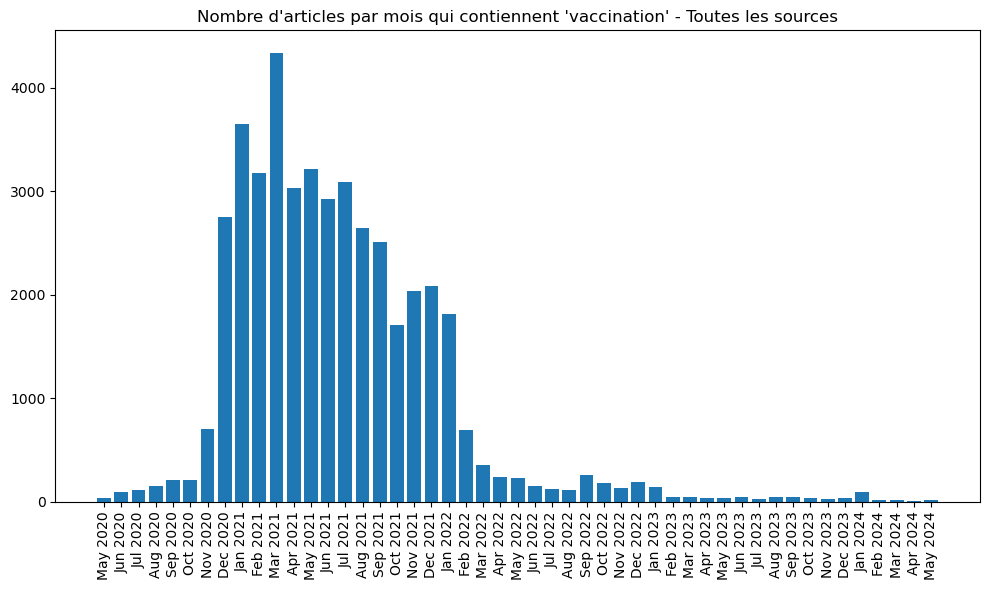

In [16]:
def expression_in_json_file(json_path, expression):
    with open(json_path, 'r', encoding="utf-8") as file:
        for line in file:
            try:
                data = json.loads(line)
                text = data.get('text')
                title = data.get('title')
                text = str(text).lower()
                title = str(title).lower()

                # Vérification pour le mot exact "anti-covid" en respectant l'ordre
                if title is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), title):
                    return True
                if text is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                    return True
            except json.JSONDecodeError:
                continue
    return False

def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")  

def get_all_months(start_date, end_date):
    all_months = []
    current_date = start_date
    while current_date <= end_date:
        all_months.append(current_date.strftime("%b %Y"))
        current_date += timedelta(days=30)  
    return all_months

def count_articles_by_month(directory, expression):
    articles_by_month = defaultdict(int)

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path) or not file_path.endswith('.json'):
            continue

        with open(file_path, 'r', encoding="utf-8") as file:
            articles_in_file = 0  # Compteur d'articles dans le fichier courant

            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    text = str(text).lower()
                    if re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                        articles_in_file += 1

                except json.JSONDecodeError:
                    continue

            if articles_in_file > 0:
                date_str = get_date_from_filename(file_path)
                articles_by_month[date_str] += articles_in_file

    return articles_by_month

if __name__ == "__main__":
    expression = input("Expression à rechercher : ")
    all_articles_by_month = defaultdict(int)

    for source in relevant_sources:
        directory = f"./data/{source}"
        articles_by_month = count_articles_by_month(directory, expression)
        
        # Ajouter les comptages de cette source aux totaux globaux
        for month, count in articles_by_month.items():
            all_articles_by_month[month] += count

    print("===================\n")
    print("Toutes les sources combinées :")
    print("===================")

    # Créer un graphique de la distribution des occurrences par mois
    all_months = get_all_months(start_date=datetime(2020, 5, 1), end_date=datetime.now())
    occurrences_by_month = [all_articles_by_month[month] for month in all_months]

    plt.figure(figsize=(10, 6))
    plt.bar(all_months, occurrences_by_month)
    plt.title(f"Nombre d'articles par mois qui contiennent '{expression}' - Toutes les sources")
    plt.xticks(rotation=90)
    plt.tight_layout()

    output_directory = "./data/plots/recherches"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    output_path = os.path.join(output_directory, f"COVID_{expression}_combined.png")
    plt.savefig(output_path)
    plt.show()
    plt.close()


#### Recherches d'expressions par source et par mois

Expression à rechercher : vaccination

lesoir.be:


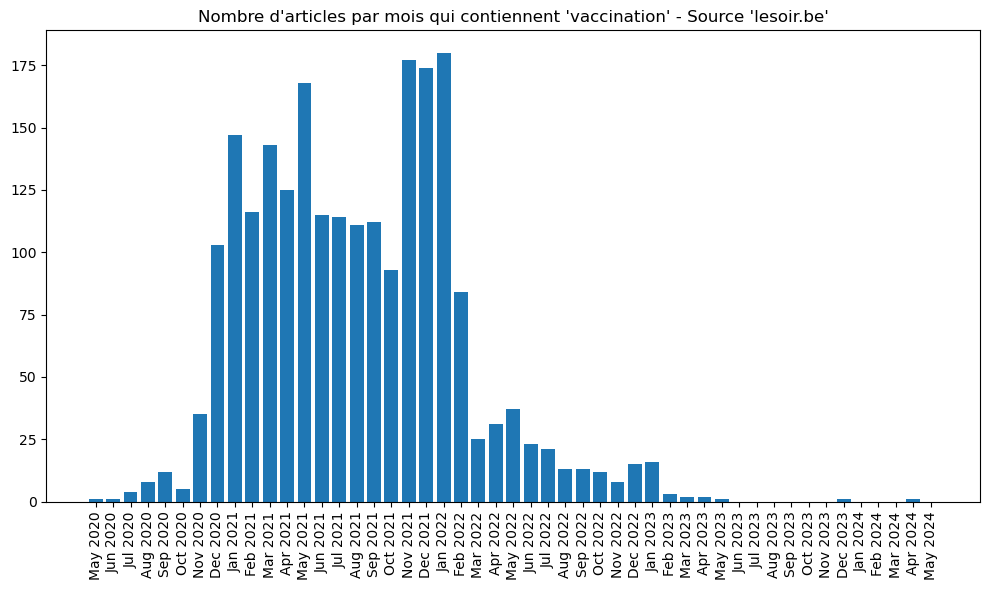


lalibre.be:


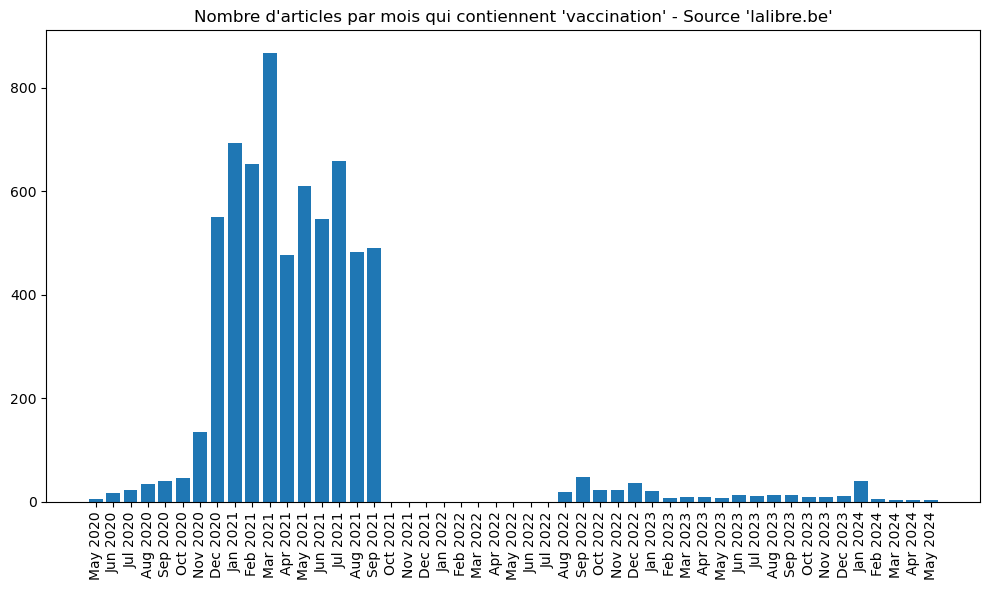


rtbf.be:


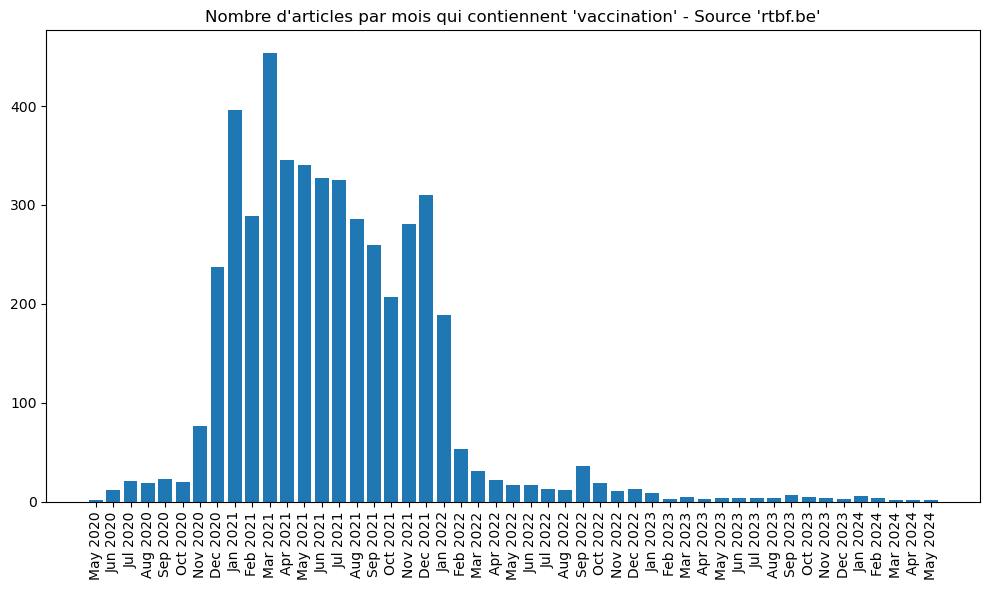


rtlinfo.be:


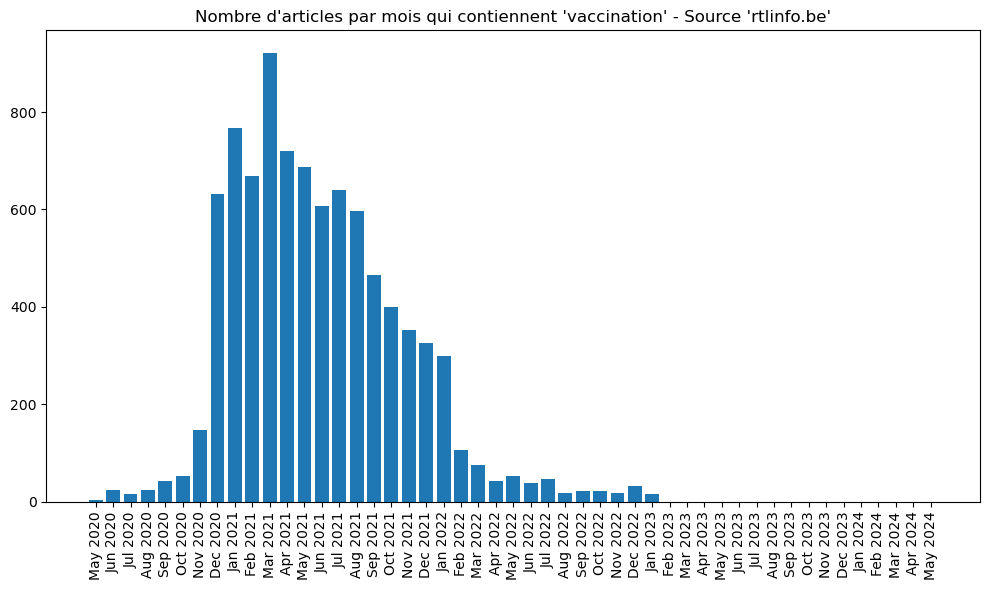


dhnet.be:


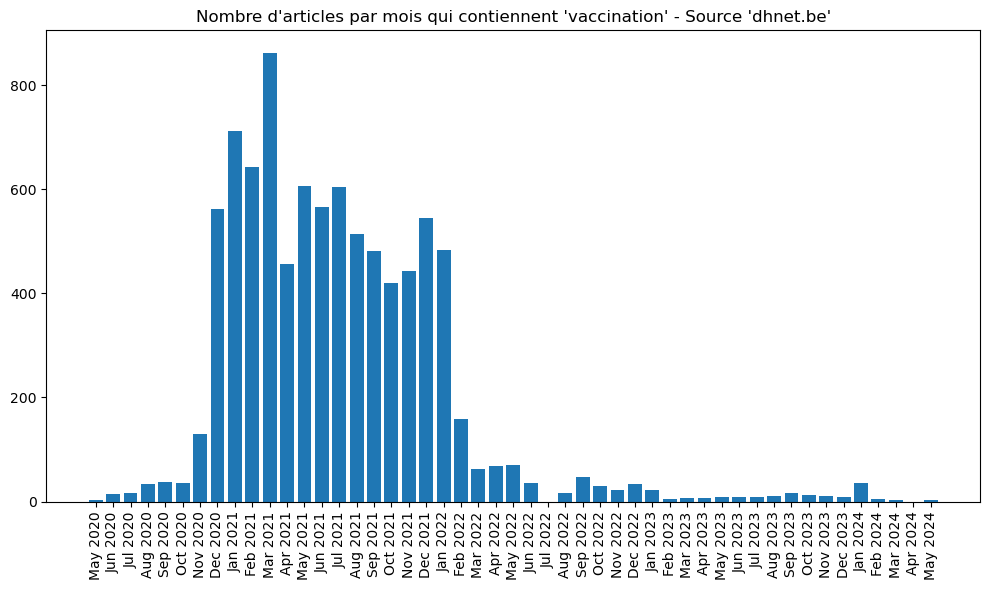


sudinfo.be:


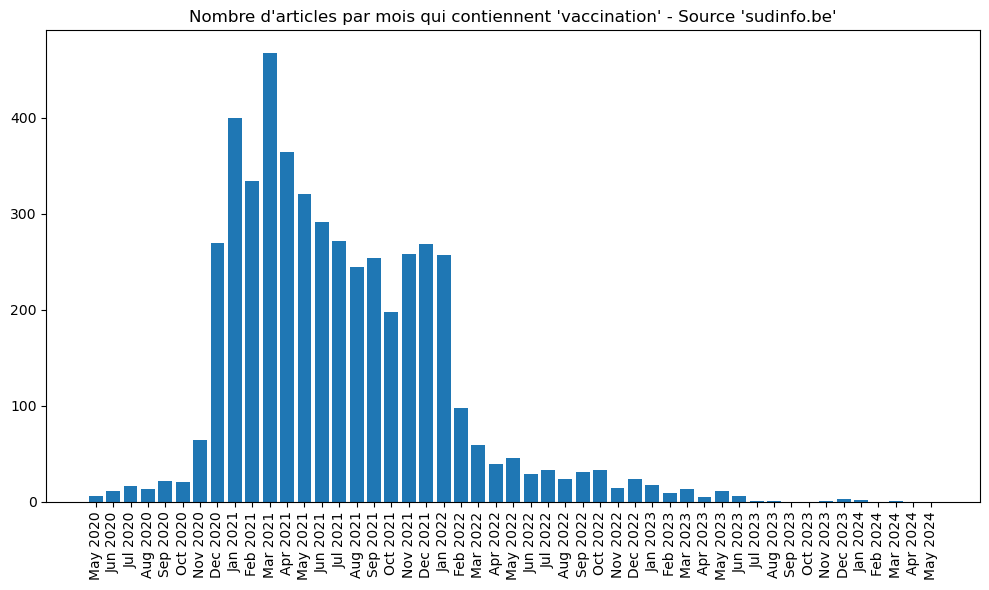


lavenir.net:


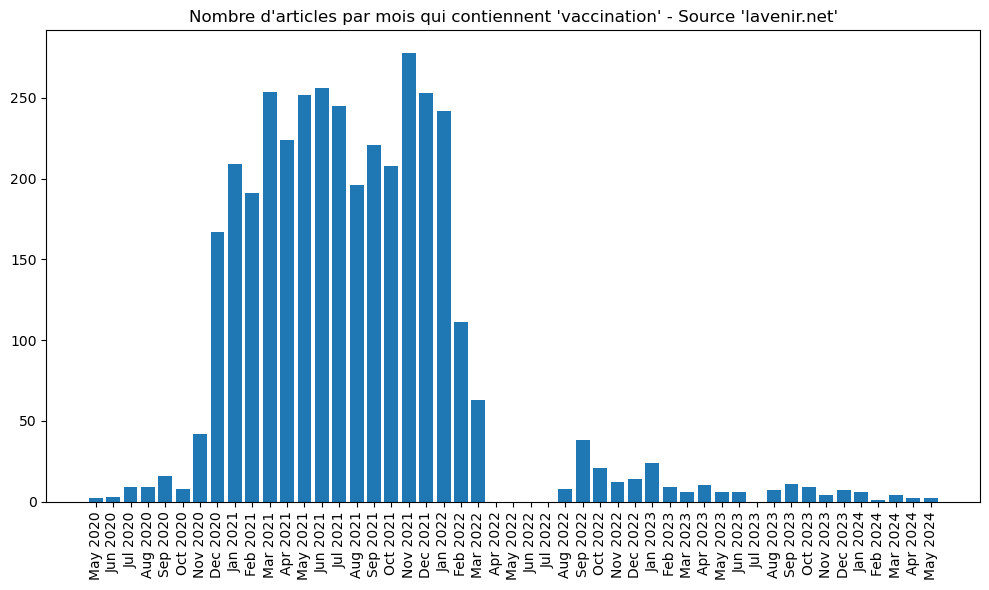


lecho.be:


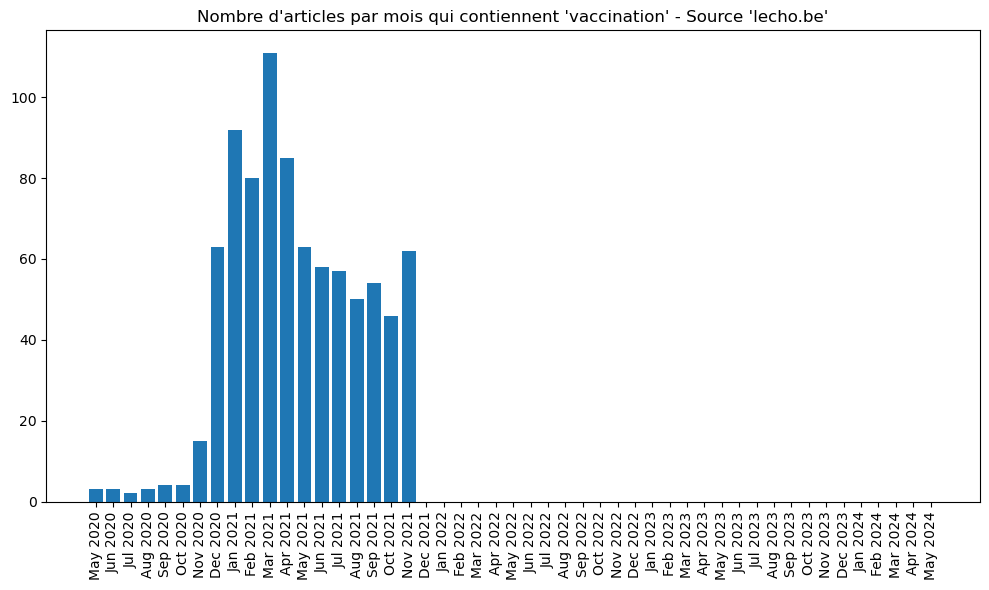


levif.be:


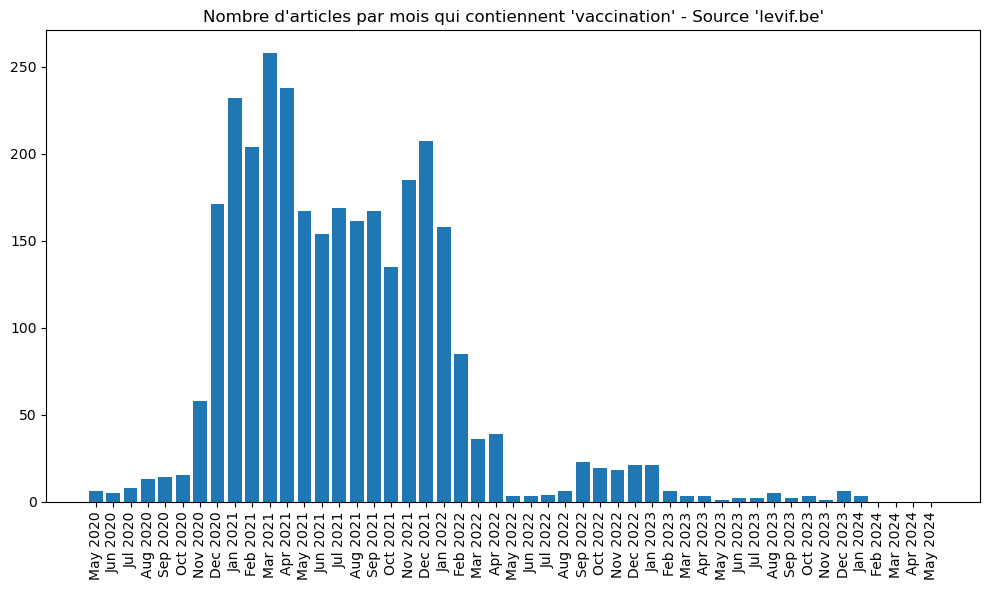

In [17]:
def expression_in_json_file(json_path, expression):
    with open(json_path, 'r', encoding="utf-8") as file:
        for line in file:
            try:
                data = json.loads(line)
                text = data.get('text')
                title = data.get('title')
                text = str(text).lower()
                title = str(title).lower()

                # Vérification pour le mot exact "anti-covid" en respectant l'ordre
                if title is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), title):
                    return True
                if text is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                    return True
            except json.JSONDecodeError:
                continue
    return False

def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")  

def get_all_months(start_date, end_date):
    all_months = []
    current_date = start_date
    while current_date <= end_date:
        all_months.append(current_date.strftime("%b %Y"))
        current_date += timedelta(days=30)  
    return all_months

if __name__ == "__main__":
    expression = input("Expression à rechercher : ")
    for source in relevant_sources:
        directory = f"./data/{source}"
        articles_by_month = count_articles_by_month(directory, expression)
        print("===================\n")
        print(f"{source}:")
        print("===================")

        # Créer un graphique de la distribution des occurrences par mois
        all_months = get_all_months(start_date=datetime(2020, 5, 1), end_date=datetime.now())
        occurrences_by_month = [articles_by_month[month] for month in all_months]

        plt.figure(figsize=(10, 6))
        plt.bar(all_months, occurrences_by_month)
        plt.title(f"Nombre d'articles par mois qui contiennent '{expression}' - Source '{source}'")
        plt.xticks(rotation=90)
        plt.tight_layout()

        output_directory = "./data/plots/recherches"
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        output_path = os.path.join(output_directory, f"COVID_{source}_{expression}.png")
        plt.savefig(output_path)
        plt.show()
        plt.close()


#### Consultation de textes aléatoires pour chaque mois en fonction de la source

In [18]:
def expression_in_json_file(json_path, expression):
    with open(json_path, 'r', encoding="utf-8") as file:
        for line in file:
            try:
                data = json.loads(line)
                text = data.get('text')
                title = data.get('title')
                text = str(text).lower()
                title = str(title).lower()

                # Vérification pour le mot exact "anti-covid" en respectant l'ordre
                if title is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), title):
                    return True
                if text is not None and re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                    return True
            except json.JSONDecodeError:
                continue
    return False

def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")  

def get_all_months(start_date, end_date):
    all_months = []
    current_date = start_date
    while current_date <= end_date:
        all_months.append(current_date.strftime("%b %Y"))
        current_date += timedelta(days=30)  
    return all_months

def expression_in_all_files(directory, expression):
    found_files = []
    total_occurrences = 0  # Compteur total d'occurrences

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path):
            continue

        if not file_path.endswith('.json'):
            continue

        occurrences_in_file = 0  # Compteur d'occurrences dans le fichier courant
        line_number = 0  # Compteur de ligne

        with open(file_path, 'r', encoding="utf-8") as file:
            for line in file:
                line_number += 1  # Incrémenter le compteur de ligne
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    text = str(text).lower()
                    if re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                        occurrences_in_file += 1  # Incrémenter le compteur du fichier
                        total_occurrences += 1  # Incrémenter le compteur total

                        # Sortir de la boucle dès qu'une occurrence est trouvée sur une ligne
                        break

                except json.JSONDecodeError:
                    continue

        if occurrences_in_file > 0:
            found_files.append(file_path)

    return found_files

def select_random_text_per_month(file_paths, expression):
    texts_per_month = {}

    # Collecter les textes par mois
    for file_path in file_paths:
        with open(file_path, 'r', encoding="utf-8") as file:
            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    text = str(text).lower()
                    if re.search(r'\b{}\b'.format(re.escape(str(expression).lower())), text):
                        date_str = get_date_from_filename(file_path)
                        if date_str not in texts_per_month:
                            texts_per_month[date_str] = []
                        texts_per_month[date_str].append(text)
                except json.JSONDecodeError:
                    continue

    # Sélectionner un texte aléatoire par mois
    selected_texts = {}
    for month, texts in texts_per_month.items():
        selected_texts[month] = random.choice(texts)

    return selected_texts

if __name__ == "__main__":
    expression = input("Expression à rechercher : ")
    print("===================\n")
    for source in relevant_sources:
        directory = f"./data/{source}"
        found_files = expression_in_all_files(directory, expression)
        print(f"{source}:")
        print("===================\n")

        # Sélectionner un texte aléatoire par mois
        selected_texts = select_random_text_per_month(found_files, expression)
        for month, text in selected_texts.items():
            print(f"{month}")
            print("---------------")
            print(text)
            print("\n---------------")


Expression à rechercher : vaccination

lesoir.be:

May 2020
---------------
la communication d’aujourd’hui étant ce qu’elle est, l’irruption de la crise actuelle a aussi été accompagnée d’une explosion de graphiques, dont twitter, linkedin, facebook et autres se sont fait les relais, entraînant de vives discussions, énormément de likes et d’implacables débats sur les formes que prendront les pics et les courbes statistiques de demain. un grand festin rhétorique auquel tout le monde se fit, et se fait encore, une joie d’assister, alimentant le bruissement général. cette profusion d’avis n’est, bien sûr, pas mauvaise en soi, et pourrait le cas échéant alimenter le débat, si l’atmosphère n’était pas à la crise. en effet, en période de crise, dans un contexte de tensions extrêmes, ce genre de débats débridés peut mener à la confusion, à la peur et à une saturation du flux d’informations, qui le cas échéant peut entraîner une certaine forme de bouleversement de la hiérarchie des information

lalibre.be:

May 2020
---------------
il n’y a aucune raison médicale valable pour exclure plus longtemps les enfants de l’école et d’activités en collectivité. ils ne sont pas les super-transmetteurs présumés comme dans la grippe. il faut surtout éviter des effets collatéraux.

une carte blanche du collectif de pédiatres de la task force pédiatrique covid-19 et d'universités (dimitri van der linden, petra schelstraete, marc raes, tyl jonckheer, pierre philippet, an bael, georges casimir, ann de guchtenaere, marie-christine seghaye, stéphane moniotte, pierre smeesters, anne tilmanne, julie frère, marc hainaut, marianne michel, etc.) retrouvez la liste complète des signataires au bas de l'article.

"mon jour préféré après mon anniversaire, c’est le jour de la rentrée des classes" : voici les mots hautement symboliques qu’une petite fille de 10 ans a glissés à son papa un soir au moment d’aller dormir…

oui, le confinement est long, très long, y compris pour les enfants… mais écoute-t-on

rtbf.be:

May 2020
---------------
coronavirus : se laver les mains, oui, mais comment ? - 21/03/2020 coronavirus : se laver les mains, oui, mais comment ? la réponse de patrice goldberg sur la première - rtbf avec arnaud ruyssen

la vente de masques est autorisée dans les grandes surfaces - jt 19h30 - 03/05/2020 dès mardi, des masques de protection seront vendus en grande surface. a quel prix ? quelles conditions ? ces masques seront-ils homologués ? voilà quelques unes des questions qui se posent. certains se demandent aussi d'où viennent tous ces stocks de la grande distribution. en france où on a pris la même mesure, certains parlent carrément de stocks cachés.

je suis (un peu) malade, je ne vais pas travailler se sentir fébrile, toussoter, avoir le nez qui coule, une légère fièvre… des symptômes qui, avant le coronavirus, ne nous auraient pas cloués au lit. tant qu’on peut se lever, on peut travailler. de plus, s’absenter pour si peu, cela serait mal vu par l’employeur. on prend 

rtlinfo.be:

May 2020
---------------
vérification de la température corporelle à jilin, dans le nord-est de la chine, le 22 mai 2020str

nouveaux bilans, nouvelles mesures, faits marquants: un point sur les dernières évolutions de la pandémie de covid-19 qui a fait plus de 335.000 morts dans le monde.

- amérique du sud: "nouvel épicentre" -

l'amérique du sud est "un nouvel épicentre" de la pandémie, avec une situation particulièrement alarmante au brésil, a estimé l'organisation mondiale de la santé.

- la russie se prépare au pire -

deuxième pays le plus affecté en nombre de cas, la russie a dit s'attendre à une "hausse significative" de la mortalité au mois de mai, tout en se félicitant d'une stabilisation de l'épidémie.

- la chine proclame sa victoire -

le premier ministre chinois li keqiang a célébré "une réussite stratégique majeure" dans le combat mené par son pays contre le nouveau coronavirus.

le géant asiatique est à présent confronté à la "tâche immense" de relancer so

dhnet.be:

May 2020
---------------
les droits des enfants à travers le monde sont "gravement affectés" par la crise du nouveau coronavirus, qui augmente les risques de travail et de mariage forcés, a annoncé mardi une organisation internationale basée à amsterdam. les conséquences économiques de la pandémie et les mesures prises par les gouvernements pour endiguer la propagation de la maladie "ont un impact désastreux sur de nombreux enfants", prévient l'ong de défense des droits des enfants kidsrights.

"cette crise fait reculer des années de progrès réalisés en matière de bien-être des enfants", a déclaré dans un communiqué marc dulleart, fondateur et président de kidsrights.

la fermeture des écoles a notamment rendu les jeunes "très vulnérables" au travail et au mariage des enfants, met en garde l'organisation.

la pression sur les soins de santé a également mis fin à certains programmes de vaccination contre des maladies telles que la polio et la rougeole et "entraînera un pic de

sudinfo.be:

May 2020
---------------
une grande campagne de vaccination contre la grippe saisonnière cette année. c’est la demande du député georges dallemagne (cdh). rassurez-vous : l’élu humaniste sait que le virus de la grippe, ce n’est pas le coronavirus et qu’il n’y a pas d’immunité croisée entre la grippe saisonnière et le covid, mais il pense que l’influenza pourrait être un ennemi très sérieux pour une série de concitoyens, à commencer par ceux qui ont été fragilisés par le virus.

« c’est un appel que je lance et je pense que le conseil supérieur de la santé va bientôt émettre une recommandation qui va dans le même sens », explique georges dallemagne. « on parle là d’une période critique qui débute au plus tôt à la fin du mois de novembre et se termine en mars de l’année suivante. chaque année, la grippe saisonnière influenza fauche quand même entre 1.000 et 1.500 vies. c’est vrai que le virus est différent du coronavirus qui sévit actuellement, mais il est quand même terribl

lavenir.net:

May 2020
---------------
environ 80 millions d’enfants de moins d’un an dans 68 pays risquent de contracter des maladies contagieuses, comme la rougeole, car la pandémie de covid-19 limite les vaccinations de routine, ont averti l’oms, l’unicef et gavi vendredi.

«cette donnée est alarmante. c’est quelque chose que nous n’avons jamais vu de toute notre vie», a déclaré le dr seth berkley, directeur exécutif de l’alliance du vaccin (gavi), au cours d’une conférence de presse virtuelle.

ce cri d’alarme est lancé à quelques jours du sommet mondial sur la vaccination qui sera virtuellement accueilli le 4 juin par le royaume-uni.

comme l’expliquent l’organisation mondiale de la santé, le fonds des nations unies pour l’enfance et gavi dans un communiqué, la pandémie limite la vaccination de routine pour plusieurs raisons.

certains parents hésitent à sortir de chez eux en raison des mesures de limitation de mouvement, du manque d’information ou parce qu’ils craignent d’être in

lecho.be:

May 2020
---------------
faute de disposer d’un vaccin dont la mise au point risque d’être longue, nous en sommes réduits à imposer aux populations des quarantaines et même des confinements qui appartiennent à des temps que l’on pensait définitivement révolus.

il faut rappeler que ni la deuxième vague, ni le rebond ne sont des fatalités, mais qu’ils le seront à coup sûr si nous perdons le contrôle de la situation.

parmi les nombreuses leçons de la pandémie à laquelle nous sommes confrontés, il nous faudra retenir que l’environnement naturel, sacralisé par certains, n’a pas cessé d’être hostile à l’homme et que la science, portée par l’idéologie du progrès, n’a pas réponse à tout. plus la compréhension de la logique du vivant progresse, plus il apparaît que l’adaptation des bactéries aux substances qu’on leur oppose et l’aptitude des virus à muter font de la lutte contre les organismes pathogènes un combat à l’issue incertaine.

claude desama professeur honoraire de l'unive

levif.be:

May 2020
---------------
rappel des faits. début avril, une jeune étudiante anversoise selena ali, est contactée par le ministère des affaires étrangères concernant le dernier vol de rapatriement du pérou, où elle effectue un stage. la jeune fille ne voyage pas seule. depuis quelques semaines, elle a adopté un félin nommé lee. lee s'est déjà fait vacciner contre la rage, et a un carnet et passeport en ordre pour le grand voyage. par ailleurs, selena reçoit l'autorisation de l'ambassade belge au pérou d'embarquer son doux chat gris lee.

au pérou, elle passe tous les contrôles et embarque dans un appareil de la compagnie air belgium.

à l'arrivée en belgique, le 6 avril en pleine période de confinement, il n'y a étrangement pas de douane pour contrôler les passagers et leurs bagages.

selena est candidate miss belgique 2020, et donne régulièrement des interviews dans la presse flamande. l'afsca tombe sur un article où elle raconte son périple et toute la tendresse qu'elle épr